In [ ]:
# Генератор данных, удаление шума, удаление периодического шума
# Метрики: SSIM, MSE. Сравните изображения.
# Изображения в оттенках серого.
# Задача 3.1
# Выполните фильтрацию изображений при  помощи преобразования Фурье.
# Сравните результаты фильтрации с алгоритмами, реализованными в task 1.
# Задача 3.2
# Обновите генератор, который Вы создали в task_1.
# Добавьте деградационный периодический шум (покомпонентноее умножение исходного и зашумленного изображения). н
# Выполните фильтрацию периодического шума при  помощи преобразования Фурье.
# Оцените качество фильтрации.
# Примеры деградационного периодического шума.

In [1]:
!unzip /content/blood.zip -d /content/

Archive:  /content/blood.zip
   creating: /content/blood/
 extracting: /content/blood/fon1.png  
 extracting: /content/blood/fon10.png  
 extracting: /content/blood/fon11.png  
 extracting: /content/blood/fon12.png  
 extracting: /content/blood/fon13.png  
 extracting: /content/blood/fon14.png  
 extracting: /content/blood/fon15.png  
 extracting: /content/blood/fon16.png  
 extracting: /content/blood/fon17.png  
 extracting: /content/blood/fon18.png  
 extracting: /content/blood/fon19.png  
 extracting: /content/blood/fon2.png  
 extracting: /content/blood/fon20.png  
 extracting: /content/blood/fon21.png  
 extracting: /content/blood/fon3.png  
 extracting: /content/blood/fon4.png  
 extracting: /content/blood/fon5.png  
 extracting: /content/blood/fon6.png  
 extracting: /content/blood/fon7.png  
 extracting: /content/blood/fon8.png  
 extracting: /content/blood/fon9.png  
 extracting: /content/blood/patch1.png  
 extracting: /content/blood/patch10.PNG  
 extracting: /content/blood/

Генерация чистого изображения...

Добавление периодического шума...


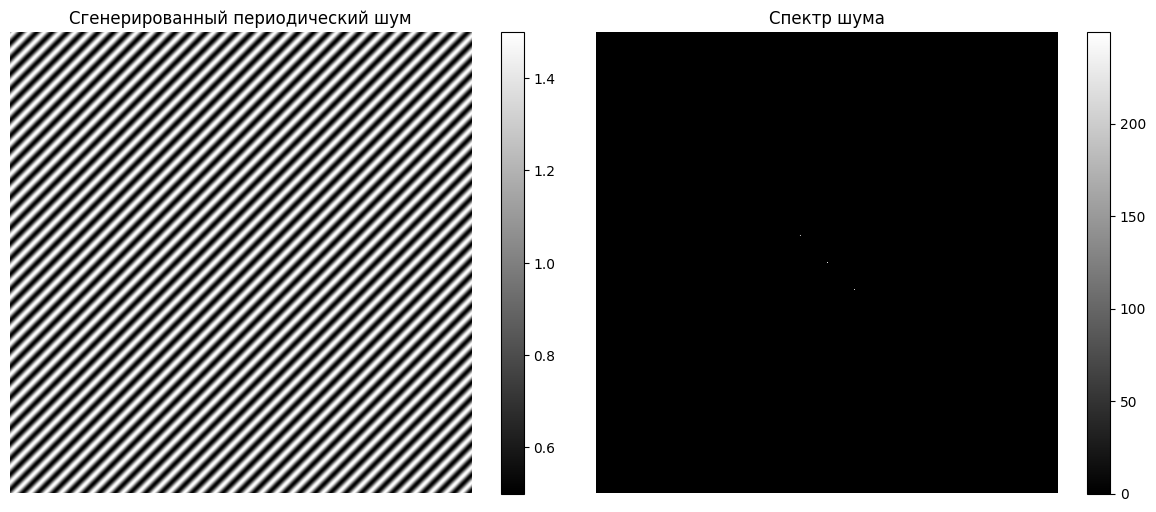


Фильтрация периодического шума...


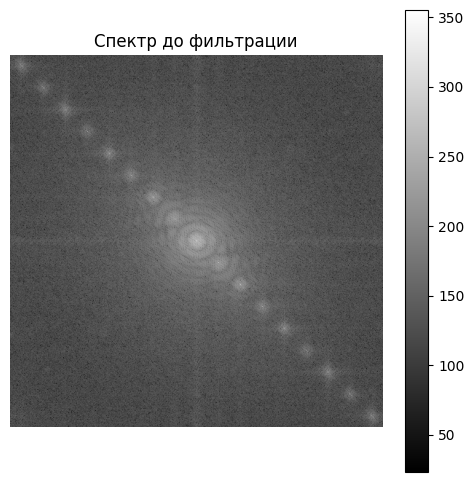

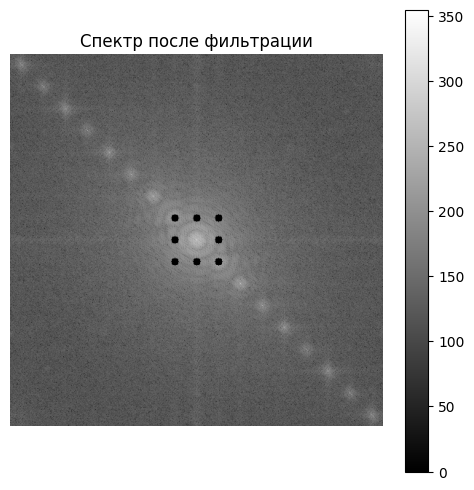


Результаты обработки:


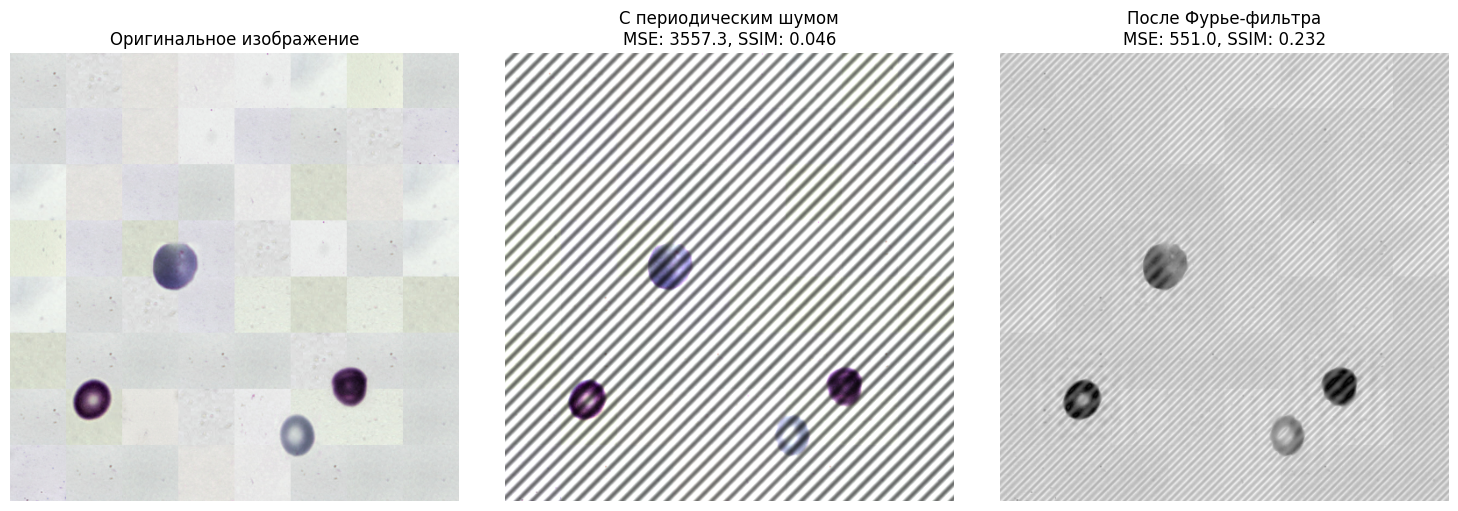

In [11]:
import os
import random
import cv2
import numpy as np
from glob import glob
from matplotlib import pyplot as plt
from skimage.metrics import mean_squared_error, structural_similarity

# Пути к данным
data_dir = "/content/blood"
generated_data_dir = "/content/generated_data"

PATCH_SIZE = (64, 64)
IMAGE_SIZE = (512, 512)
NUM_CELLS_RANGE = (2, 10)

# Загружаем пути к файлам
cell_files = glob(os.path.join(data_dir, "patch*"))
background_files = glob(os.path.join(data_dir, "fon*"))

if not cell_files or not background_files:
    raise ValueError("Не найдены файлы клеток или фона в папке 'blood'!")

# Функция для создания случайного фонового изображения 512x512
def create_background(image_size=IMAGE_SIZE):
    background = np.zeros((image_size[1], image_size[0], 3), dtype=np.uint8)
    patch_size = PATCH_SIZE

    num_patches_x = image_size[0] // patch_size[0]
    num_patches_y = image_size[1] // patch_size[1]

    for i in range(num_patches_y):
        for j in range(num_patches_x):
            patch = cv2.imread(random.choice(background_files))
            if patch is None:
                continue
            patch = cv2.resize(patch, patch_size, interpolation=cv2.INTER_AREA)
            background[i * patch_size[1]:(i + 1) * patch_size[1], j * patch_size[0]:(j + 1) * patch_size[0]] = patch

    return background

# Функция для наложения клеток на фон
def place_cell(background, cell):
    bg_h, bg_w, _ = background.shape
    cell_h, cell_w, _ = cell.shape
    mask = 255 * np.ones((cell_h, cell_w), dtype=np.uint8)
    x = random.randint(0, bg_w - cell_w)
    y = random.randint(0, bg_h - cell_h)
    center = (x + cell_w // 2, y + cell_h // 2)
    return cv2.seamlessClone(cell, background, mask, center, cv2.NORMAL_CLONE)

# Функция для генерации и визуализации периодического шума
def generate_and_visualize_noise(image_shape, freq=30, amplitude=0.5):
    x = np.arange(0, image_shape[1])
    y = np.arange(0, image_shape[0])
    xx, yy = np.meshgrid(x, y)

    # Генерируем шум
    noise = 1 + amplitude * np.sin(2 * np.pi * freq * xx / image_shape[1] +
                                 2 * np.pi * freq * yy / image_shape[0])

    # Визуализация шума
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(noise, cmap='gray')
    plt.title('Сгенерированный периодический шум')
    plt.colorbar()
    plt.axis('off')

    # Визуализация спектра шума
    noise_spectrum = np.fft.fft2(noise)
    noise_spectrum_shift = np.fft.fftshift(noise_spectrum)
    magnitude_spectrum = 20 * np.log(np.abs(noise_spectrum_shift) + 1)

    plt.subplot(1, 2, 2)
    plt.imshow(magnitude_spectrum, cmap='gray')
    plt.title('Спектр шума')
    plt.colorbar()
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    return noise

# Функция для добавления периодического шума (мультипликативный)
def add_periodic_noise(image, freq=30, amplitude=0.5):
    noise = generate_and_visualize_noise(image.shape[:2], freq, amplitude)
    noisy_image = image.astype(np.float32) * noise[:, :, np.newaxis]
    return np.clip(noisy_image, 0, 255).astype(np.uint8)

# Функция для визуализации Фурье-спектра изображения
def plot_spectrum(image, title):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    dft = np.fft.fft2(gray)
    dft_shift = np.fft.fftshift(dft)
    magnitude_spectrum = 20 * np.log(np.abs(dft_shift) + 1)

    plt.figure(figsize=(6, 6))
    plt.imshow(magnitude_spectrum, cmap='gray')
    plt.title(title)
    plt.colorbar()
    plt.axis('off')
    plt.show()

# Функция для удаления периодического шума с помощью Фурье
def remove_periodic_noise(image, freq=30):
    # Конвертируем в grayscale для обработки
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Применяем Фурье-преобразование
    dft = np.fft.fft2(gray)
    dft_shift = np.fft.fftshift(dft)

    # Визуализация спектра до фильтрации
    plot_spectrum(image, "Спектр до фильтрации")

    # Создаем маску для фильтрации
    rows, cols = gray.shape
    crow, ccol = rows // 2, cols // 2
    mask = np.ones((rows, cols), np.uint8)

    # Удаляем высокочастотные компоненты (периодический шум)
    radius = 5
    for i in range(-1, 2):
        for j in range(-1, 2):
            if i == 0 and j == 0:
                continue
            cv2.circle(mask, (ccol + i*freq, crow + j*freq), radius, 0, -1)
            cv2.circle(mask, (ccol - i*freq, crow - j*freq), radius, 0, -1)

    # Применяем маску
    fshift = dft_shift * mask

    # Визуализация спектра после фильтрации
    plt.figure(figsize=(6, 6))
    plt.imshow(20 * np.log(np.abs(fshift) + 1), cmap='gray')
    plt.title("Спектр после фильтрации")
    plt.colorbar()
    plt.axis('off')
    plt.show()

    # Обратное Фурье-преобразование
    f_ishift = np.fft.ifftshift(fshift)
    img_back = np.fft.ifft2(f_ishift)
    restored = np.abs(img_back)

    # Масштабируем и конвертируем обратно в BGR
    restored = cv2.normalize(restored, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    return cv2.cvtColor(restored, cv2.COLOR_GRAY2BGR)

# Функция для расчета метрик (в оттенках серого)
def calculate_metrics(original, processed):
    original_gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
    processed_gray = cv2.cvtColor(processed, cv2.COLOR_BGR2GRAY)

    mse = mean_squared_error(original_gray, processed_gray)
    ssim = structural_similarity(original_gray, processed_gray)

    return mse, ssim

# Основной код
if __name__ == "__main__":
    # Создаем папку для результатов
    os.makedirs(generated_data_dir, exist_ok=True)

    # Генерируем чистое изображение
    print("Генерация чистого изображения...")
    background = create_background()
    clean_image = background.copy()
    num_cells = random.randint(NUM_CELLS_RANGE[0], NUM_CELLS_RANGE[1])

    for _ in range(num_cells):
        cell = cv2.imread(random.choice(cell_files))
        if cell is None:
            continue
        cell = cv2.resize(cell, PATCH_SIZE, interpolation=cv2.INTER_AREA)
        clean_image = place_cell(clean_image, cell)

    # Добавляем периодический шум
    print("\nДобавление периодического шума...")
    noisy_periodic = add_periodic_noise(clean_image.copy())

    # Фильтруем периодический шум
    print("\nФильтрация периодического шума...")
    restored_image = remove_periodic_noise(noisy_periodic.copy())

    # Рассчитываем метрики
    mse_periodic, ssim_periodic = calculate_metrics(clean_image, noisy_periodic)
    mse_restored, ssim_restored = calculate_metrics(clean_image, restored_image)

    # Визуализация результатов
    print("\nРезультаты обработки:")
    plt.figure(figsize=(15, 5))

    plt.subplot(131), plt.imshow(cv2.cvtColor(clean_image, cv2.COLOR_BGR2RGB))
    plt.title('Оригинальное изображение'), plt.axis('off')

    plt.subplot(132), plt.imshow(cv2.cvtColor(noisy_periodic, cv2.COLOR_BGR2RGB))
    plt.title(f'С периодическим шумом\nMSE: {mse_periodic:.1f}, SSIM: {ssim_periodic:.3f}'), plt.axis('off')

    plt.subplot(133), plt.imshow(cv2.cvtColor(restored_image, cv2.COLOR_BGR2RGB))
    plt.title(f'После Фурье-фильтра\nMSE: {mse_restored:.1f}, SSIM: {ssim_restored:.3f}'), plt.axis('off')

    plt.tight_layout()
    plt.show()